## This file simulates a learning CRN consisting of two CBMs coupled to a bistable toggle switch (the environment).

In [1]:
# Helper Functions and Imports

%matplotlib inline
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
import numpy as np
import pylab as plt
from scipy.sparse import csc_matrix
import matplotlib
from time import process_time
import itertools


#Detailed Balanced Reaction
def db_rxns(inputs, outputs, EnergyDict, k = 1.):
    dE = sum([EnergyDict[o] for o in outputs])-sum([EnergyDict[i] for i in inputs])
    rxn1 = [inputs, outputs, "massaction", {"k":k*np.exp(-dE/2)}]
    rxn2 = [outputs, inputs, "massaction", {"k":k*np.exp(dE/2)}]
    return [rxn1, rxn2]

#Detailed Balanced Reaction with Chemostats (meant to be simulated with clamping implemented as rules)
def chemostat_db_rxns(inputs, outputs, input_chemostats, output_chemostats, EnergyDict, k = 1):
    dE = sum([EnergyDict[o] for o in outputs])-sum([EnergyDict[i] for i in inputs])
    
    kf = ""
    for i in input_chemostats+inputs:
        kf += i+"*"
    kf += str(np.exp(-dE/2)*k)
    
    kr = ""
    for o in output_chemostats+outputs:
        kr += o + "*"
    kr += str(np.exp(dE/2)*k)
    
    rxn1 = [inputs, outputs, "general", {"rate":kf}]
    rxn2 = [outputs, inputs, "general", {"rate":kr}]
    #print(inputs, "-->", outputs, "@", kf)
    #print(outputs, "-->", inputs, "@", kr)
    return [rxn1, rxn2]

#Learning Rule
def add_learning_rule(M, P, Q, X, k, dt):
    if isinstance(k, tuple):
        k1 = k[0]
        k2 = k[1]
    else:
        k1 = k
        k2 = k
    M.create_rule("assignment", {"equation":f"{P} = {P}+{P}*({k1}*{X}-{k2}*{Q})*{dt}"})

#Edge Species Chemical Boltzmann Machine reactions
def ECBM_rxns(flip, neighbors, edges, potentials, E, clamped_species = [], k = 1):
    reactions = []
    combos = itertools.product([0, 1], repeat = len(neighbors))
    for c in combos:
        inputs = [flip+"_0"]
        outputs = [flip + "_1"]
        chemo_in = []
        chemo_out = []
        if flip in potentials:
            plist = []
            if isinstance(potentials[flip], str):
                plist.append(potentials[flip])
            else:
                plist = potentials[flip]
            for p in plist:
                chemo_in.append(p+"_0")
                chemo_out.append(p+"_1")
        for i in range(len(c)):
            inputs.append(neighbors[i]+f"_{c[i]}")
            outputs.append(neighbors[i]+f"_{c[i]}")
            if c[i] == 1:
                inputs.append(edges(flip, neighbors[i])+"_0")
                outputs.append(edges(flip, neighbors[i])+"_1")
                
                if edges(flip, neighbors[i]) in potentials and flip not in clamped_species:
                    plist = []
                    if isinstance(potentials[edges(flip, neighbors[i])], str):
                        plist.append(potentials[edges(flip, neighbors[i])])
                    else:
                        plist = potentials[edges(flip, neighbors[i])]
                    for p in plist:
                        chemo_in.append(p+"_0")
                        chemo_out.append(p+"_1")
        reactions += chemostat_db_rxns(inputs, outputs, chemo_in, chemo_out, E, k)
    return reactions


## Global Parameters for the simulation

In [2]:
#global rates
k_ev = 250
k_learn = .01
kdb = 100.

#Toggle switch model
ktx = 10.0*k_ev
ktl = 10.0*k_ev
delta = 2.*k_ev
kb = 1000.*k_ev
ku = 100.*k_ev
n = 2
k_leak = ktx/200
alpha = delta**2/((ktx+k_leak)*ktl)

k_copy = k_ev/100
k_copy = (k_copy, k_copy*alpha)
dt = .001

### Create Bistable Toggle CRN

[(['G0'], ['G0', 'T0'], 'massaction', {'k': 2500.0}), (['G1'], ['G1', 'T1'], 'massaction', {'k': 2500.0}), (['T0'], ['R0', 'T0'], 'massaction', {'k': 2500.0}), (['T1'], ['R1', 'T1'], 'massaction', {'k': 2500.0}), (['R1', 'R1', 'G0'], ['G0R1'], 'massaction', {'k': 250000.0}), (['R0', 'R0', 'G1'], ['G1R0'], 'massaction', {'k': 250000.0}), (['G0R1'], ['R1', 'R1', 'G0'], 'massaction', {'k': 25000.0}), (['G1R0'], ['R0', 'R0', 'G1'], 'massaction', {'k': 25000.0}), (['R0'], [], 'massaction', {'k': 500.0}), (['R1'], [], 'massaction', {'k': 500.0}), (['T0'], [], 'massaction', {'k': 500.0}), (['T1'], [], 'massaction', {'k': 500.0}), (['G0R1'], ['G0R1', 'T0'], 'massaction', {'k': 12.5}), (['G1R0'], ['G1R0', 'T1'], 'massaction', {'k': 12.5})]


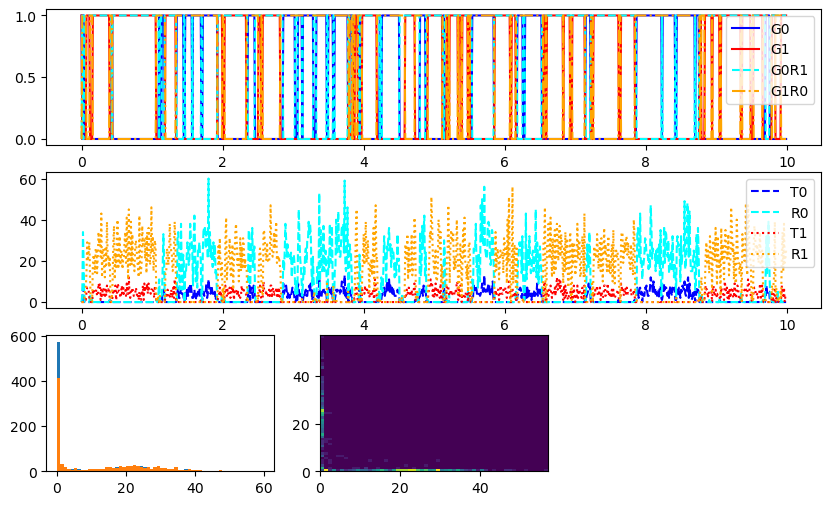

In [3]:
speciesXOR = ["G0", "R0", "G0R1", "G1", "R1", "G1R0", "T0", "T1"]

reactionsXOR = [
    (["G0"], ["G0", "T0"], "massaction", {"k":ktx}), (["G1"], ["G1", "T1"], "massaction", {"k":ktx}),
    (["T0"], ["R0", "T0"], "massaction", {"k":ktl}), (["T1"], ["R1", "T1"], "massaction", {"k":ktl}),
    (n*["R1"]+["G0"], ["G0R1"], "massaction", {"k":kb}), (n*["R0"]+["G1"], ["G1R0"], "massaction", {"k":kb}),
    (["G0R1"], n*["R1"]+["G0"], "massaction", {"k":ku}), (["G1R0"], n*["R0"]+["G1"], "massaction", {"k":ku}),
    (["R0"], [], "massaction", {"k":delta}), (["R1"], [], "massaction", {"k":delta}),
    (["T0"], [], "massaction", {"k":delta}), (["T1"], [], "massaction", {"k":delta}),
    (["G0R1"], ["G0R1", "T0"], "massaction", {"k":k_leak}), (["G1R0"], ["G1R0", "T1"], "massaction", {"k":k_leak}),
]

print(reactionsXOR)
x0XOR = {s:0 for s in speciesXOR}
x0XOR.update({"G0":1, "G1":1})
CRN = Model(species = speciesXOR, reactions = reactionsXOR, initial_condition_dict = x0XOR)

maxtime = 10
timepoints = np.arange(0, maxtime, maxtime/1000)
R = py_simulate_model(timepoints, CRN, return_dataframe = False, stochastic = True)
df = R.py_get_dataframe(Model = CRN)
hmR = R.py_empirical_distribution(species = ["R0", "R1"], Model = CRN, start_time = int(maxtime/2))
hmG = R.py_empirical_distribution(species = ["G0", "G1"], Model = CRN, start_time = int(maxtime/2))


plt.figure(figsize = (10, 6))
plt.subplot(311)
plt.plot(timepoints, df["G0"], color = "blue", label = "G0")
plt.plot(timepoints, df["G1"], color = "red", label = "G1")
plt.plot(timepoints, df["G0R1"],"--", color = "cyan", label = "G0R1")
plt.plot(timepoints, df["G1R0"], "-.", color = "orange", label = "G1R0")
plt.legend()

plt.subplot(312)
plt.plot(timepoints, df["T0"], "--", color = "blue", label = "T0")
plt.plot(timepoints, df["R0"], "--", color = "cyan", label = "R0")
plt.plot(timepoints, df["T1"], ":", color = "red", label = "T1")
plt.plot(timepoints, df["R1"], ":", color = "orange", label = "R1")
plt.legend()

plt.subplot(337)
bins = range(0, int(max(max(df["R0"]), max(df["R1"])))+1, 1)
plt.hist(df["R0"], bins = bins)
plt.hist(df["R1"], bins = bins)

plt.subplot(338)
plt.pcolormesh(hmR)

plt.subplot(338)
plt.pcolormesh(hmG)

### CRN implementation of a 3-Node ECBM

In [4]:
#Free Species
speciesX = ["X0_0", "X0_1", "X1_0", "X1_1", "H_0", "H_1"]
speciesW =["W0_0", "W0_1", "W1_0", "W1_1"]

#Clamped Species
speciesQ =["Q0_0", "Q0_1", "Q1_0", "Q1_1", "QH_0", "QH_1"]
speciesQW =["QW0_0", "QW0_1", "QW1_0", "QW1_1"]

#Potential Species
speciesP =["PX0_0", "PX0_1", "PX1_0", "PX1_1", "PH_0", "PH_1", "PW0_0", "PW0_1", "PW1_0", "PW1_1", "PQ0_0", "PQ0_1", "PQ1_0", "PQ1_1"]

#Environment Species

species = speciesX+speciesQ+speciesW+speciesQW+speciesP+speciesXOR

E = {s:0 for s in species}

potentials = {s.split("_")[0]:"P"+s.split("_")[0] for s in speciesX + speciesW}
potentials.update({s.split("_")[0]:"P"+s.split("_")[0][1:] for s in speciesQW+["QH_0", "QH_1"]})
potentials.update({"Q0":["PQ0", "PX0"], "Q1":["PQ1", "PX1"]})

edge_dict = {
    ("X0", "H"):"W0", ("X1", "H"):"W1",
    ("Q0", "QH"):"QW0", ("Q1", "QH"):"QW1",
    ("E0", "E1"):"EW"
}
def edges(x, y):
    if (x, y) in edge_dict:
        return edge_dict[x, y]
    elif (y, x) in edge_dict:
        return edge_dict[y, x]
    else:
        raise ValueError(f"Edge {x}, {y} not in edge_dict")

clamped = []
reactions_free = []
reactions_free += ECBM_rxns("X0", ["H"], edges, potentials, E, clamped, kdb)
reactions_free += ECBM_rxns("X1", ["H"], edges, potentials, E, clamped, kdb)
reactions_free += ECBM_rxns("H", ["X0", "X1"], edges, potentials, E, clamped, kdb)

reactions_clamped = []
reactions_clamped += ECBM_rxns("Q0", ["QH"], edges, potentials, E, clamped, kdb)
reactions_clamped += ECBM_rxns("Q1", ["QH"], edges, potentials, E, clamped, kdb)
reactions_clamped += ECBM_rxns("QH", ["Q0", "Q1"], edges, potentials, E, clamped, kdb)

reactions = reactions_free + reactions_clamped + reactionsXOR

x0 = {}
for s in species:
    if s not in x0:
        if "P" not in s:
            x0[s] = int("_0" in s)
        else:
            if "_0" in s:
                p0 = s
                p1 = s[:-1]+"1"
            else:
                p0 = s[:-1]+"0"
                p1 = s
            
            x0[p0] = 1.0
            x0[p1] = 1.0

x0.update(x0XOR)
    
M = Model(species = species, reactions = reactions, initial_condition_dict = x0)

add_learning_rule(M, "PX0_0", "Q0_0", "X0_0", k_learn, dt)
add_learning_rule(M, "PX0_1", "Q0_1", "X0_1", k_learn, dt)
add_learning_rule(M, "PX1_0", "Q1_0", "X1_0", k_learn, dt)
add_learning_rule(M, "PX1_1", "Q1_1", "X1_1", k_learn, dt)

add_learning_rule(M, "PH_0", "QH_0", "H_0", k_learn, dt)
add_learning_rule(M, "PH_1", "QH_1", "H_1", k_learn, dt)


add_learning_rule(M, "PW0_0", "QW0_0", "W0_0", k_learn, dt)
add_learning_rule(M, "PW0_1", "QW0_1", "W0_1", k_learn, dt)
add_learning_rule(M, "PW1_0", "QW1_0", "W1_0", k_learn, dt)
add_learning_rule(M, "PW1_1", "QW1_1", "W1_1", k_learn, dt)

add_learning_rule(M, "PQ0_1", "R0", "Q0_1", k_copy, dt)
add_learning_rule(M, "PQ1_1", "R1", "Q1_1", k_copy, dt)


print(potentials)

for r in reactions:
    print(r)

{'X0': 'PX0', 'X1': 'PX1', 'H': 'PH', 'W0': 'PW0', 'W1': 'PW1', 'QW0': 'PW0', 'QW1': 'PW1', 'QH': 'PH', 'Q0': ['PQ0', 'PX0'], 'Q1': ['PQ1', 'PX1']}
[['X0_0', 'H_0'], ['X0_1', 'H_0'], 'general', {'rate': 'PX0_0*X0_0*H_0*100.0'}]
[['X0_1', 'H_0'], ['X0_0', 'H_0'], 'general', {'rate': 'PX0_1*X0_1*H_0*100.0'}]
[['X0_0', 'H_1', 'W0_0'], ['X0_1', 'H_1', 'W0_1'], 'general', {'rate': 'PX0_0*PW0_0*X0_0*H_1*W0_0*100.0'}]
[['X0_1', 'H_1', 'W0_1'], ['X0_0', 'H_1', 'W0_0'], 'general', {'rate': 'PX0_1*PW0_1*X0_1*H_1*W0_1*100.0'}]
[['X1_0', 'H_0'], ['X1_1', 'H_0'], 'general', {'rate': 'PX1_0*X1_0*H_0*100.0'}]
[['X1_1', 'H_0'], ['X1_0', 'H_0'], 'general', {'rate': 'PX1_1*X1_1*H_0*100.0'}]
[['X1_0', 'H_1', 'W1_0'], ['X1_1', 'H_1', 'W1_1'], 'general', {'rate': 'PX1_0*PW1_0*X1_0*H_1*W1_0*100.0'}]
[['X1_1', 'H_1', 'W1_1'], ['X1_0', 'H_1', 'W1_0'], 'general', {'rate': 'PX1_1*PW1_1*X1_1*H_1*W1_1*100.0'}]
[['H_0', 'X0_0', 'X1_0'], ['H_1', 'X0_0', 'X1_0'], 'general', {'rate': 'PH_0*H_0*X0_0*X1_0*100.0'}]
[['H

### Run the Simulation

starting simulation...
Learning Simulating Complete.
Computing Distributions


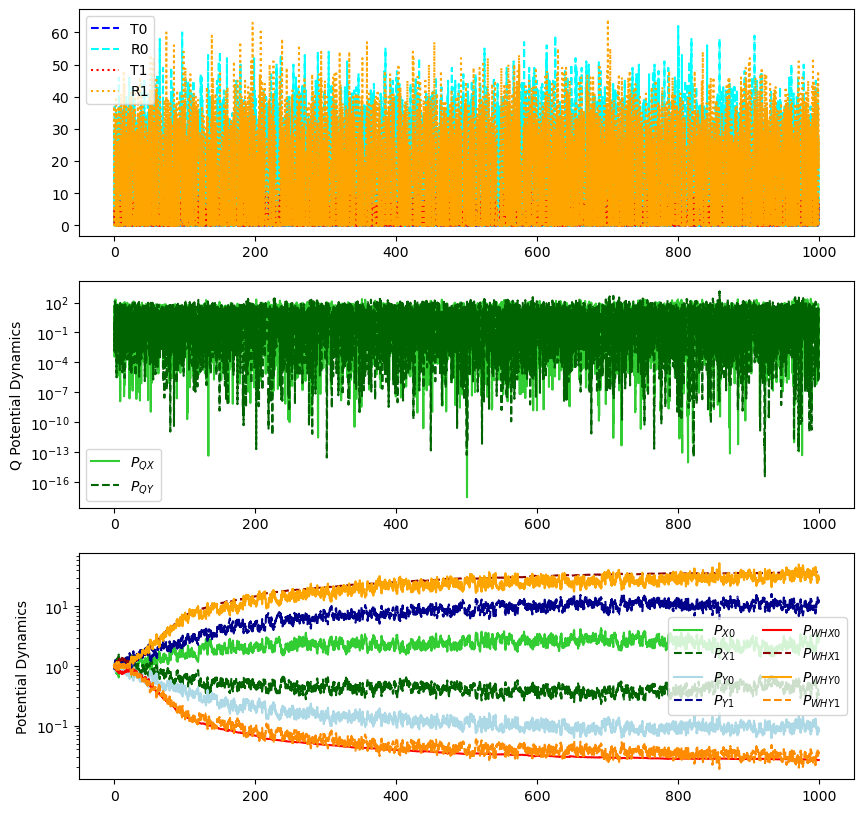

In [5]:
max_time = 1000
timepoints = np.arange(0, max_time, dt)
burn_in = max_time/10
print("starting simulation...")
results = py_simulate_model(timepoints, M, stochastic = True, return_dataframe = False); print("Learning Simulating Complete.")
R = results.py_get_dataframe(Model = M)
print("Computing Distributions")
dist_Q = results.py_empirical_distribution(species = ["Q0_1", "Q1_1"], start_time = burn_in, Model = M, max_counts = [1, 1])

maxR = max(max(R["R0"]), max(R["R1"]))
dist_E = results.py_empirical_distribution(species = ["R0", "R1"], start_time = burn_in, Model = M, max_counts = [maxR, maxR])

plt.figure(figsize = (10, 10))
plt.subplot(311)
plt.plot(timepoints[::100], R["T0"][::100], "--", color = "blue", label = "T0")
plt.plot(timepoints[::100], R["R0"][::100], "--", color = "cyan", label = "R0")
plt.plot(timepoints[::100], R["T1"][::100], ":", color = "red", label = "T1")
plt.plot(timepoints[::100], R["R1"][::100], ":", color = "orange", label = "R1")
plt.legend()
plt.subplot(312)

plt.ylabel("Q Potential Dynamics")
plt.plot(timepoints[::100], R["PQ0_1"][::100], color = "limegreen", label = "$P_{QX}$")
plt.plot(timepoints[::100], R["PQ1_1"][::100],"--", color = "darkgreen", label = "$P_{QY}$")
#plt.plot(timepoints[::100], R["PQ1_0"][::100], color = "lightblue", label = "PQ1_0")
#plt.plot(timepoints[::100], R["PQ1_0"][::100],"--", color = "darkblue", label = "PQ1_1")
plt.yscale('log')
plt.legend()

plt.subplot(313)
plt.ylabel("Potential Dynamics")
plt.plot(timepoints[::100], R["PX0_0"][::100], color = "limegreen", label = "$P_{X0}$")
plt.plot(timepoints[::100], R["PX0_1"][::100],"--", color = "darkgreen", label = "$P_{X1}$")
plt.plot(timepoints[::100], R["PX1_0"][::100], color = "lightblue", label = "$P_{Y0}$")
plt.plot(timepoints[::100], R["PX1_1"][::100],"--", color = "darkblue", label = "$P_{Y1}$")
plt.plot(timepoints[::100], R["PW0_0"][::100], color = "red", label = "$P_{WHX0}$")
plt.plot(timepoints[::100], R["PW0_1"][::100],"--", color = "darkred", label = "$P_{WHX1}$")
plt.plot(timepoints[::100], R["PW1_0"][::100], color = "orange", label = "$P_{WHY0}$")
plt.plot(timepoints[::100], R["PW1_1"][::100],"--", color = "darkorange", label = "$P_{WHY1}$")
plt.legend()
plt.yscale('log')
plt.legend(ncol = 2)

### Simulating initial and final models

Simulating Free Model
Calculating Dist
{'X0_0': 1, 'X0_1': 0, 'X1_0': 1, 'X1_1': 0, 'H_0': 1, 'H_1': 0, 'W0_0': 1, 'W0_1': 0, 'W1_0': 1, 'W1_1': 0, 'PX0_0': 2.2674262157541274, 'PX0_1': 0.4534817723146175, 'PX1_0': 0.09598859725080493, 'PX1_1': 10.623603172555473, 'PH_0': 0.8222823943640506, 'PH_1': 1.2387801732313755, 'PW0_0': 0.0276658901676815, 'PW0_1': 36.14685187756504, 'PW1_0': 31.922914714794373, 'PW1_1': 0.03198105341296444, 'PQ0_0': 1.0, 'PQ0_1': 17.93303792300256, 'PQ1_0': 1.0, 'PQ1_1': 21.802931272189763}
All simulations complete


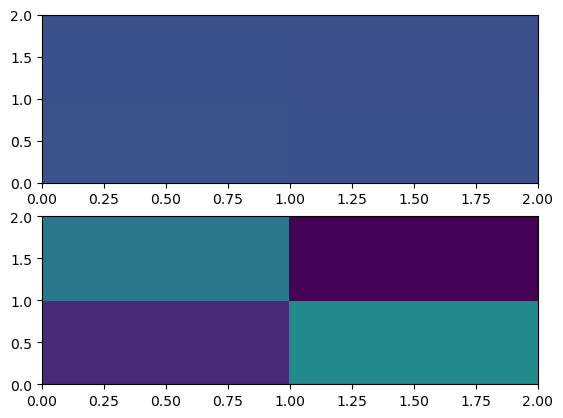

In [6]:
print("Simulating Free Model")

maxtime = 2000
time = np.arange(0, maxtime, 1.0)


species_free = speciesX + speciesW + speciesP
x0_i = {s:1.0*x0[s] for s in species_free}



M_free_i = Model(species = species_free, reactions = reactions_free, initial_condition_dict = x0_i)
results_free_i = py_simulate_model(time, M_free_i, stochastic = True, return_dataframe = False)



print("Calculating Dist")
dist_free_i = results_free_i.py_empirical_distribution(species = ["X0_1", "X1_1"], start_time = burn_in, Model = M_free_i, max_counts = [1, 1])


x0_f = {s:x0[s] for s in species_free}
for p in speciesP:
    x0_f[p] = np.mean(R[p][int(4*len(timepoints)/5):])
print(x0_f)


M_free_f = Model(species = species_free, reactions = reactions_free, initial_condition_dict = x0_f)
results_free_f = py_simulate_model(time, M_free_f, stochastic = True, return_dataframe = False)
dist_free_f = results_free_f.py_empirical_distribution(species = ["X0_1", "X1_1"], start_time = burn_in, Model = M_free_f, max_counts = [1, 1])
print("All simulations complete")

plt.subplot(211)
plt.pcolor(dist_free_i, vmin = 0, vmax = 1)

plt.subplot(212)
plt.pcolor(dist_free_f, vmin = 0, vmax = 1)

### Produce the Figure in the Manuscript

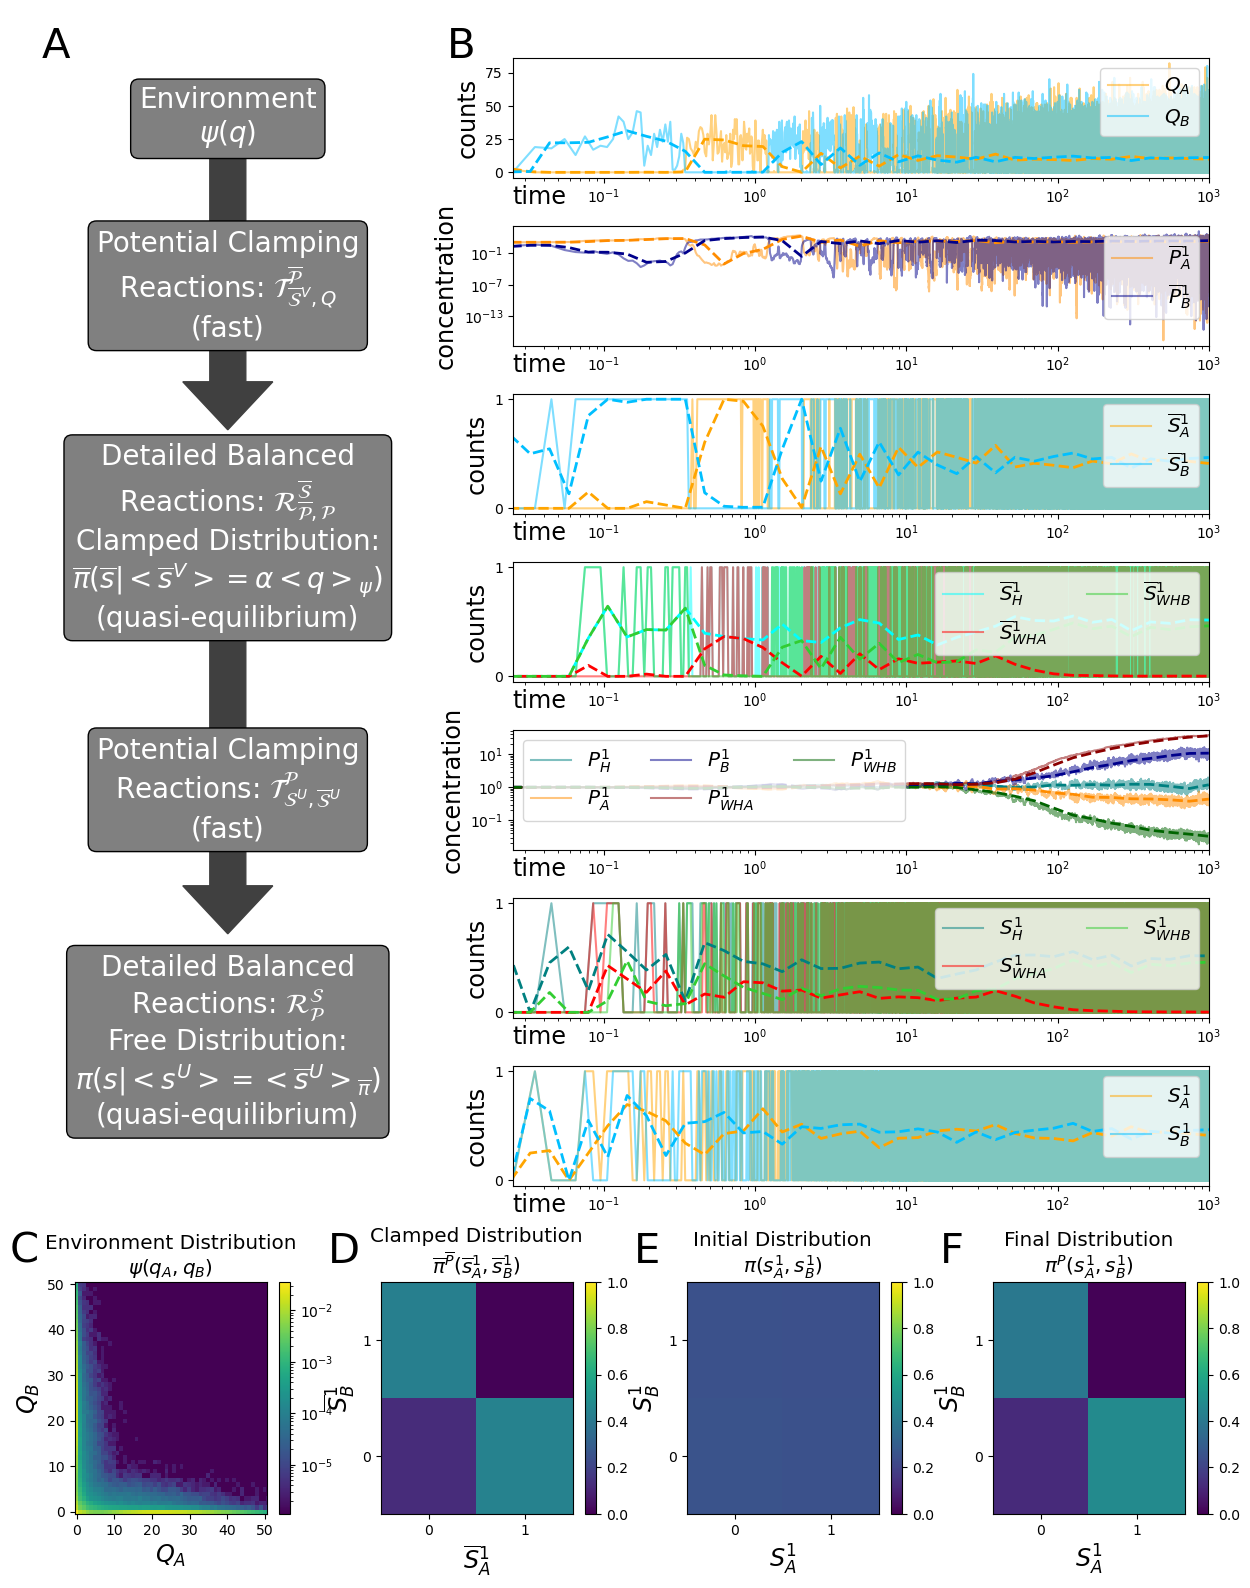

In [7]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize = (12, 16))

start_time = int(.025/dt)
plot_step = 10
plot_time = int(len(timepoints))
avg_bins = np.concatenate(([0], np.logspace(-2, 3, 40)))
#Bottom corner and spacing
c0 = .055
r0 = .06

#Bottom row
w1 = .2
h1 = .2 - c0

#left panel
w0 = w1
h0 = 1-h1-2*r0

#Right panels
n = 7 #Number of axes
r2 = 2*r0 + h1
c2 = 4*c0+w1
w2 = 1 - c2
h2 = h0/n - r0/2

c0b = 2*c0+h1/2

ax0 = plt.axes((c0, 2*r0 + h1, w1, h0))


ax8 = plt.axes((c2, r2 + 6*(r0/2+ h2), w2, h2))
ax7 = plt.axes((c2, r2 + 5*(r0/2+ h2), w2, h2))
ax6 = plt.axes((c2, r2 + 4*(r0/2+ h2), w2, h2))
ax5 = plt.axes((c2, r2 + 3*(r0/2+ h2), w2, h2))
ax4 = plt.axes((c2, r2 + 2*(r0/2+ h2), w2, h2))
ax3 = plt.axes((c2, r2 + 1*(r0/2+ h2), w2, h2))
ax2 = plt.axes((c2, r2 + 0*(r0/2+ h2), w2, h2))

ax1a = plt.axes((c0, r0, w1, h1))
ax1b = plt.axes((2*c0+1*w1, r0, w1, h1))
ax1c = plt.axes((3*c0+2*w1, r0, w1, h1))
ax1d = plt.axes((4*c0+3*w1, r0, w1, h1))



plt.sca(ax0)
plt.text(c0/2, 1-r0/2, "A", fontsize = 30, transform=fig.transFigure)

plt.text(c2-c0, 1-r0/2, "B", fontsize = 30, transform=fig.transFigure)

plt.text(c0/5-.01, h1+1.2*r0, "C", fontsize = 30, transform=fig.transFigure)
plt.text(c0/5+(w1+c0), h1+1.2*r0, "D", fontsize = 30, transform=fig.transFigure)
plt.text(c0/5+2*(w1+c0), h1+1.2*r0, "E", fontsize = 30, transform=fig.transFigure)
plt.text(c0/5+3*(w1+c0), h1+1.2*r0, "F", fontsize = 30, transform=fig.transFigure)


ax0.axis('off')
aw = .03
s = 0.01
fs = 20
plt.arrow(c0b, r2 + 6*(r0/2+ h2)+h2/2-s, 0, -2.2*h2-r0/2+s, transform=fig.transFigure, 
          color = '.25', width = aw, length_includes_head = True,
         head_length = aw, head_width = aw*2.5)


plt.arrow(c0b, r2 + 3*(r0/2+ h2)+h2/2-s, 0, -2.2*h2-r0/2+s, transform=fig.transFigure, 
          color = '.25', width = aw, length_includes_head = True,
         head_length = aw, head_width = aw*2.5)

box = dict(boxstyle='round', facecolor='gray', alpha=1.0)

plt.text(c0b, r2 + 6*(r0/2+ h2)+h2/2, "Environment\n$\psi(q)$", 
         transform=fig.transFigure, va = "center",  ha = "center", 
         fontsize = fs, bbox = box, color = 'white')

plt.text(c0b, r2 + 5*(r0/2+ h2)+h2/2, 
         """Potential Clamping\nReactions: $\mathcal{T}^\overline{\mathcal{P}}_{\overline{\mathcal{S}}^V, Q}$\n(fast)""", 
         transform=fig.transFigure, va = "center",  ha = "center", 
         fontsize = fs, bbox = box, color = 'white')


plt.text(c0b, r2 + 3.5*(r0/2+ h2)+h2/2, 
         """Detailed Balanced\nReactions: $\mathcal{R}^{\overline{\mathcal{S}}}_{\overline{\mathcal{P}},\mathcal{P}}$\nClamped Distribution:\n$\overline{\pi}(\overline{s} | <\overline{s}^V>= \\alpha <q>_\psi)$\n(quasi-equilibrium)""", 
         transform=fig.transFigure, va = "center",  ha = "center", 
         fontsize = fs, bbox = box, color = 'white')

#plt.text(c0b, r2 + 3*(r0/2+ h2)+h2/2, "Free Hidden Units\n$\pi(\overline{S}^U | <\overline{S}^V>= \\alpha <Q>)$", 
#         transform=fig.transFigure, va = "center", ha = "center",  
#         fontsize = fs, bbox = box, color = 'white')

plt.text(c0b, r2 + 2*(r0/2+ h2)+h2/2, 
        """Potential Clamping\nReactions: $\mathcal{T}^\mathcal{P}_{\mathcal{S}^U, \overline{\mathcal{S}}^U}$\n(fast)""", 
         transform=fig.transFigure, va = "center", ha = "center", 
         fontsize = fs, bbox = box, color = 'white')

plt.text(c0b, r2 + 1*.5*(r0/2+ h2)+h2/2, 
         """Detailed Balanced\nReactions: $\mathcal{R}^{\mathcal{S}}_{\mathcal{P}}$\nFree Distribution:\n$\pi(s | <s^U>= <\overline{s}^U>_{\overline{\pi}})$\n(quasi-equilibrium)""", 
         transform=fig.transFigure, va = "center", ha = "center",  
         fontsize = fs, bbox = box, color = 'white')


plt.sca(ax8)
plt.plot(timepoints[start_time:plot_time:plot_step], R["R0"][start_time:plot_time:plot_step], color = "orange", label = "$Q_A$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["R1"][start_time:plot_time:plot_step], color = "deepskyblue", label = "$Q_B$", alpha = .5)

R0_binned_avg = [np.mean(R["R0"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], R0_binned_avg, "--", color = "orange", lw = 2)
R1_binned_avg = [np.mean(R["R1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], R1_binned_avg, "--", color = "deepskyblue", lw = 2)


plt.legend(ncol = 1, loc = 1, fontsize = 'x-large')
plt.xticks([], [])
plt.xlabel("time", loc = 'left', labelpad = -15, fontsize = 'xx-large')
plt.ylabel("counts", fontsize = 'xx-large')
plt.xscale('log')
plt.xlim(.25*10**-1, 10**3)


plt.sca(ax7)
plt.plot(timepoints[start_time:plot_time:plot_step], R["PQ0_1"][start_time:plot_time:plot_step], color = "darkorange", label = "$\overline{P}^1_{A}$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["PQ1_1"][start_time:plot_time:plot_step], color = "darkblue", label = "$\overline{P}^1_{B}$", alpha = .5)


PQ0_1_binned_avg = [np.mean(R["PQ0_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], PQ0_1_binned_avg, "--", color = "darkorange", lw = 2)
PQ1_1_binned_avg = [np.mean(R["PQ1_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], PQ1_1_binned_avg, "--", color = "darkblue", lw = 2)

plt.yscale('log')
plt.legend(ncol = 1, loc = 1, fontsize = 'x-large')
plt.xticks([], [])
plt.xlabel("time", loc = 'left', labelpad = -15, fontsize = 'xx-large')
plt.ylabel("concentration", fontsize = 'xx-large')
plt.xscale('log')
plt.xlim(.25*10**-1, 10**3)


plt.sca(ax6)
plt.plot(timepoints[start_time:plot_time:plot_step], R["Q0_1"][start_time:plot_time:plot_step], color = "orange", label = "$\overline{S}^1_A$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["Q1_1"][start_time:plot_time:plot_step], color = "deepskyblue", label = "$\overline{S}^1_B$", alpha = .5)

Q0_1_binned_avg = [np.mean(R["Q0_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], Q0_1_binned_avg, "--", color = "orange", lw = 2)
Q1_1_binned_avg = [np.mean(R["Q1_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], Q1_1_binned_avg, "--", color = "deepskyblue", lw = 2)


plt.legend(ncol = 1, loc = 1, fontsize = 'x-large')
plt.xticks([], [])
plt.yticks([0, 1], ["0", "1"])
plt.xlabel("time", loc = 'left', labelpad = -15, fontsize = 'xx-large')
plt.ylabel("counts", fontsize = 'xx-large')
plt.xscale('log')
plt.xlim(.25*10**-1, 10**3)


plt.sca(ax5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["QH_1"][start_time:plot_time:plot_step], color = "cyan", label = "$\overline{S}_H^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["QW0_1"][start_time:plot_time:plot_step], color = "red", label = "$\overline{S}_{WHA}^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["QW1_1"][start_time:plot_time:plot_step], color = "limegreen", label = "$\overline{S}_{WHB}^1$", alpha = .5)


QH_1_binned_avg = [np.mean(R["QH_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], QH_1_binned_avg, "--", color = "cyan", lw = 2)
QW0_1_binned_avg = [np.mean(R["QW0_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], QW0_1_binned_avg, "--", color = "red", lw = 2)
QW1_1_binned_avg = [np.mean(R["QW1_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], QW1_1_binned_avg, "--", color = "limegreen", lw = 2)

plt.legend(ncol = 2, loc = 1, fontsize = 'x-large')
plt.xticks([], [])
plt.yticks([0, 1], ["0", "1"])
plt.xlabel("time", loc = 'left', labelpad = -15, fontsize = 'xx-large')
plt.ylabel("counts", fontsize = 'xx-large')
plt.xscale('log')
plt.xlim(.25*10**-1, 10**3)


plt.sca(ax4)
#plt.ylabel("Potential Dynamics")
plt.plot(timepoints[start_time:plot_time:plot_step], R["PH_1"][start_time:plot_time:plot_step], color = "teal", label = "$P_{H}^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["PX0_1"][start_time:plot_time:plot_step], color = "darkorange", label = "$P_{A}^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["PX1_1"][start_time:plot_time:plot_step], color = "darkblue", label = "$P_{B}^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["PW0_1"][start_time:plot_time:plot_step], color = "darkred", label = "$P_{WHA}^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["PW1_1"][start_time:plot_time:plot_step], color = "darkgreen", label = "$P_{WHB}^1$", alpha = .5)


PH_1_binned_avg = [np.mean(R["PH_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], PH_1_binned_avg, "--", color = "teal", lw = 2)
PX0_1_binned_avg = [np.mean(R["PX0_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], PX0_1_binned_avg, "--", color = "darkorange", lw = 2)
PX1_1_binned_avg = [np.mean(R["PX1_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], PX1_1_binned_avg, "--", color = "darkblue", lw = 2)
PW0_1_binned_avg = [np.mean(R["PW0_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], PW0_1_binned_avg, "--", color = "darkred", lw = 2)
PW1_1_binned_avg = [np.mean(R["PW1_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], PW1_1_binned_avg, "--", color = "darkgreen", lw = 2)

plt.legend()
plt.yscale('log')
plt.legend(ncol = 3, loc = 2, fontsize = 'x-large')
plt.xticks([], [])
plt.xlabel("time", loc = 'left', labelpad = -15, fontsize = 'xx-large')
plt.ylabel("concentration", fontsize = 'xx-large')
plt.xscale('log')
plt.xlim(.25*10**-1, 10**3)


plt.sca(ax3)
#Free Hidden Species
plt.plot(timepoints[start_time:plot_time:plot_step], R["H_1"][start_time:plot_time:plot_step], color = "teal", label = "$S_H^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["W0_1"][start_time:plot_time:plot_step], color = "red", label = "$S_{WHA}^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["W1_1"][start_time:plot_time:plot_step], color = "limegreen", label = "$S_{WHB}^1$", alpha = .5)


H_1_binned_avg = [np.mean(R["H_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], H_1_binned_avg, "--", color = "teal", lw = 2)
W0_1_binned_avg = [np.mean(R["W0_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], W0_1_binned_avg, "--", color = "red", lw = 2)
W1_1_binned_avg = [np.mean(R["W1_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], W1_1_binned_avg, "--", color = "limegreen", lw = 2)

plt.legend(ncol = 2, loc = 1, fontsize = 'x-large')
plt.xticks([], [])
plt.yticks([0, 1], ["0", "1"])
plt.xlabel("time", loc = 'left', labelpad = -15, fontsize = 'xx-large')
plt.xlim(.25*10**-1, 10**3)
plt.ylabel("counts", fontsize = 'xx-large')
plt.xscale('log')


plt.sca(ax2)
plt.plot(timepoints[start_time:plot_time:plot_step], R["X0_1"][start_time:plot_time:plot_step], color = "orange", label = "$S_A^1$", alpha = .5)
plt.plot(timepoints[start_time:plot_time:plot_step], R["X1_1"][start_time:plot_time:plot_step], color = "deepskyblue", label = "$S_B^1$", alpha = .5)

X0_1_binned_avg = [np.mean(R["X0_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], X0_1_binned_avg, "--", color = "orange", lw = 2)
X1_1_binned_avg = [np.mean(R["X1_1"].to_numpy()[(timepoints>=avg_bins[i])*(timepoints<avg_bins[i+1])]) for i in range(len(avg_bins)-1)]
plt.plot(avg_bins[1:], X1_1_binned_avg, "--", color = "deepskyblue", lw = 2)

plt.legend(ncol = 1, loc = 1, fontsize = 'x-large')

plt.yticks([0, 1], ["0", "1"])
plt.xlabel("time", loc = 'left', labelpad = -15, fontsize = 'xx-large')
plt.ylabel("counts", fontsize = 'xx-large')
plt.xscale('log')
plt.xlim(.25*10**-1, 10**3)
#plt.xticks(None, [])


plt.sca(ax1a)
plt.title('Environment Distribution\n$\psi(q_A, q_B)$', fontsize = 'x-large')

downsample = 1
if downsample not in [1, None]:
    dist = np.zeros((int(dist_E.shape[0]/downsample)+1, int(dist_E.shape[0]/downsample)+1))
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            ii, jj = int(i/downsample), int(j/downsample)
            dist[ii, jj] += dist_E[i, j]
else:
    dist = dist_E

lognorm = LogNorm(vmin = np.min(dist[np.nonzero(dist)]), vmax = np.max(dist[np.nonzero(dist)]))
dist = dist + np.min(dist[np.nonzero(dist)])
#dist = dist
cb = plt.pcolor(dist, norm = lognorm)
plt.colorbar(cb)
plt.xlim(0, 51)
plt.ylim(0, 51)
tick_range = list(range(0, 51, 10))
plt.xticks(np.array(tick_range)+.5, [str(s) for s in tick_range])
plt.yticks(np.array(tick_range)+.5, [str(s) for s in tick_range])
plt.xlabel("$Q_A$", fontsize = 'xx-large')
plt.ylabel("$Q_B$", fontsize = 'xx-large')


plt.sca(ax1b)
lognorm = LogNorm(vmin = np.min(dist_Q[np.nonzero(dist_Q)]), vmax = np.max(dist_Q[np.nonzero(dist_Q)]))
plt.title('Clamped Distribution\n$\overline{\pi}^\overline{P}(\overline{s}_A^1, \overline{s}_B^1)$', fontsize = 'x-large')
cb = plt.pcolor(dist_Q, vmin = 0, vmax = 1)
plt.colorbar(cb)
plt.xticks([.5, 1.5], ["0", "1"])
plt.yticks([.5, 1.5], ["0", "1"])
plt.xlabel("$\overline{S}_A^1$", fontsize = 'xx-large')
plt.ylabel("$\overline{S}_B^1$", fontsize = 'xx-large')

plt.sca(ax1c)
lognorm = LogNorm(vmin = np.min(dist_free_i[np.nonzero(dist_free_i)]), vmax = np.max(dist_free_i[np.nonzero(dist_free_i)]))
plt.title('Initial Distribution\n$\pi(s_A^1, s_B^1)$', fontsize = 'x-large')
cb = plt.pcolor(dist_free_i, vmin = 0, vmax = 1)
plt.colorbar(cb)
plt.xticks([.5, 1.5], ["0", "1"])
plt.yticks([.5, 1.5], ["0", "1"])
plt.xlabel("$S_A^1$", fontsize = 'xx-large')
plt.ylabel("$S_B^1$", fontsize = 'xx-large')

plt.sca(ax1d)
lognorm = LogNorm(vmin = np.min(dist_free_f[np.nonzero(dist_free_f)]), vmax = np.max(dist_free_f[np.nonzero(dist_free_f)]))
plt.title('Final Distribution\n$\pi^P(s_A^1, s_B^1)$', fontsize = 'x-large')
cb = plt.pcolor(dist_free_f, vmin = 0, vmax = 1)
plt.colorbar(cb)
plt.xticks([.5, 1.5], ["0", "1"])
plt.yticks([.5, 1.5], ["0", "1"])
plt.xlabel("$S_A^1$", fontsize = 'xx-large')
plt.ylabel("$S_B^1$", fontsize = 'xx-large')

plt.savefig("learning_crn_fig.pdf")
plt.savefig("learning_crn_fig.eps")
plt.savefig("learning_crn_fig.png")